In [1]:
import pathlib as pl
import shutil
import dakota.environment as dakenv
import sys, os
import numpy as np

# script_dir = pl.Path(__file__).parent
script_dir = pl.Path(os.getcwd())  ## how resilient is this?
print(script_dir)
sys.path.append(script_dir)

from utils import funs_create_dakota_conf, funs_data_processing

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation


In [2]:
data_dir = script_dir / "transformed_data_Cedric"
TRAINING_SAMPLES_FILE = data_dir / "itrainsample.csv"
TEST_SAMPLES_FILE = data_dir / "itestsample.csv"

## Load & process input data

In [3]:
tmp_folder = script_dir / ".tmp_output"
if tmp_folder.exists():
    shutil.rmtree(tmp_folder)
tmp_folder.mkdir()
TRAINING_SAMPLES_FILE = shutil.copy(TRAINING_SAMPLES_FILE, tmp_folder)
TEST_SAMPLES_FILE = shutil.copy(TEST_SAMPLES_FILE, tmp_folder)

In [4]:
PROCESSED_TRAINING_FILE = funs_data_processing.process_input_file(
    TRAINING_SAMPLES_FILE, columns_to_remove=["Interface"]
)
PROCESSED_TEST_FILE = funs_data_processing.process_input_file(
    TEST_SAMPLES_FILE,
    columns_to_remove=["AfPeak", "aAfPeak", "res", "ares", "nres", "anres"],
    # remove the output column; needs to be evaluated
)

In [5]:
variables_train = funs_data_processing.get_variable_names(PROCESSED_TRAINING_FILE)
print(variables_train)
variables_test = funs_data_processing.get_variable_names(PROCESSED_TEST_FILE)
print(variables_test)

['Id', 'Depth', 'Diameter', 'Angle', 'ThicknessSkin', 'ThicknessSct', 'ThicknessAponeurosis', 'ThicknessLooseAreolarTissue', 'ThicknessSkullOuter', 'ThicknessSkullDiploe', 'ThicknessSkullInner', 'ThicknessCsf', 'ConductivitySkin', 'ConductivitySct', 'ConductivityAponeurosis', 'ConductivityLooseAreolarTissue', 'ConductivitySkullCortical', 'ConductivitySkullDiploe', 'ConductivityCsf', 'AfPeak']
['Id', 'Depth', 'Diameter', 'Angle', 'ThicknessSkin', 'ThicknessSct', 'ThicknessAponeurosis', 'ThicknessLooseAreolarTissue', 'ThicknessSkullOuter', 'ThicknessSkullDiploe', 'ThicknessSkullInner', 'ThicknessCsf', 'ConductivitySkin', 'ConductivitySct', 'ConductivityAponeurosis', 'ConductivityLooseAreolarTissue', 'ConductivitySkullCortical', 'ConductivitySkullDiploe', 'ConductivityCsf']


## Plot input data (Fig03 & Fig07)

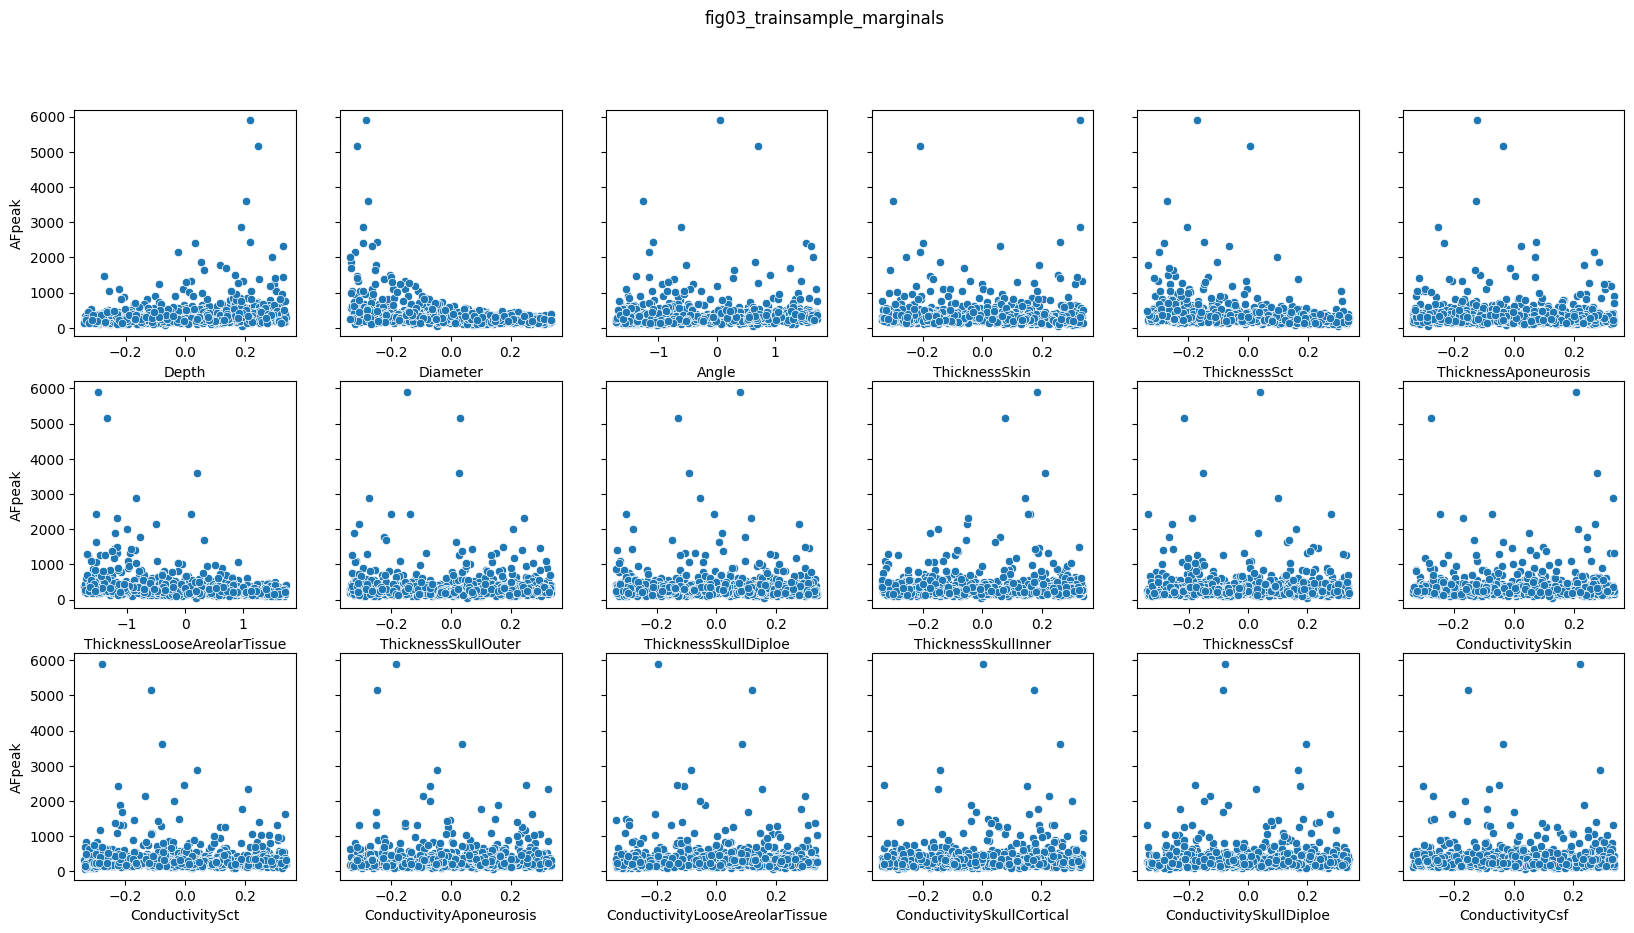

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

title = "fig03_trainsample_marginals"
fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
data = funs_data_processing.load_data(PROCESSED_TRAINING_FILE)
data = data.astype(np.float64)
data.rename(columns={"AfPeak": "AFpeak"}, inplace=True)
data.head()
axs: List[plt.Axes] = axs.flatten()
# fig, axs = plt.subplots(1,1, figsize=(15, 15), sharey=True)
# axs = [axs]
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="AFpeak", ax=ax)
    # plt.scatter(data[c].values, data["AFpeak"].values)
    ax.set_xlabel(c)
    # ax.hlines(0.0, data[c].min(), data[c].max(), color="black", linestyle="--")
plt.suptitle(title)
plt.show()

## Create & run Dakota study

In [7]:
dakota_conf_path = tmp_folder / "dakota.in"
dakota_conf = funs_create_dakota_conf.start_dakota_file()
dakota_conf += funs_create_dakota_conf.add_surrogate_model(
    PROCESSED_TRAINING_FILE,
    cross_validation_folds=None,
)
dakota_conf += funs_create_dakota_conf.add_evaluation_method(PROCESSED_TEST_FILE)
dakota_conf += funs_create_dakota_conf.add_variables(
    variables=variables_train[1:-1],
)
dakota_conf += funs_create_dakota_conf.add_responses(variables_train[-1])
print(dakota_conf)
funs_create_dakota_conf.write_to_file(dakota_conf, dakota_conf_path)


    environment
        tabular_data
            tabular_data_file = 'results.dat'
    

        model
            id_model 'SURR_MODEL'
            surrogate global
                gaussian_process surfpack
                ## hopefully faster by removing CV
                import_build_points_file 
                    '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/itrainsample_processed.txt'
                    custom_annotated header eval_id
                export_approx_points_file "predictions.dat"
                export_approx_variance_file "variances.dat"
        
        method
            id_method "EVALUATION"
            output debug
            model_pointer 'SURR_MODEL'
        
            list_parameter_study
                import_points_file 
                    ## this file should be wo responses!!
                    '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output

In [8]:
# os.chdir(tmp_folder)
# study = dakenv.study(
#     callbacks={},  ## DONT NEED ANY MODEL EVALUATIONS
#     input_string=dakota_conf,
# )
# study.execute()
# os.chdir(script_dir)

os.chdir(tmp_folder)
shutil.copy(script_dir / "execute_dakota.py", tmp_folder)
!python execute_dakota.py
os.chdir(script_dir)

# import subprocess

# subprocess.run(
#     " ".join(["dakota", "-i", str(dakota_conf_path), "-o", "rest.out"]),
#     shell=True,
#     cwd=tmp_folder,
# )

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output
Dakota version 6.19+ (stable) released Aug  8 2024.
Repository revision 494027b (2024-04-29) built Aug  8 2024 14:37:02.
Running serial Dakota executable in serial mode.
Start time: Tue Sep  3 18:32:13 2024

Using provided Dakota input string
Writing new restart file 'dakota.rst'.
Surrogate model retrieving points with 18 variables and 1 response
functions from file '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/itrainsample_processed.txt'
Variables read:
                     -2.2670800000e-01 Depth
                      5.2842800000e-02 Diameter
                     -1.7108100000e+00 Angle
                      9.9354500000e-02 ThicknessSkin
                      1.1395700000e-01 ThicknessSct
                      2.0592400000e-01 ThicknessAponeurosis
                      7.3469200000e-01 ThicknessLooseAreolarTissue
                  

## Evaluate Dakota predictions

In [9]:
y = funs_data_processing.get_results(TEST_SAMPLES_FILE, "AfPeak")
y_hat = funs_data_processing.get_results(tmp_folder / "predictions.dat", "AfPeak")
std = np.sqrt(
    funs_data_processing.get_results(tmp_folder / "variances.dat", "AfPeak_variance")
)
y_tilde = (y - y_hat) / std

k =  1.5
The data IS normally distributed. p-value: 0.41140394067929237


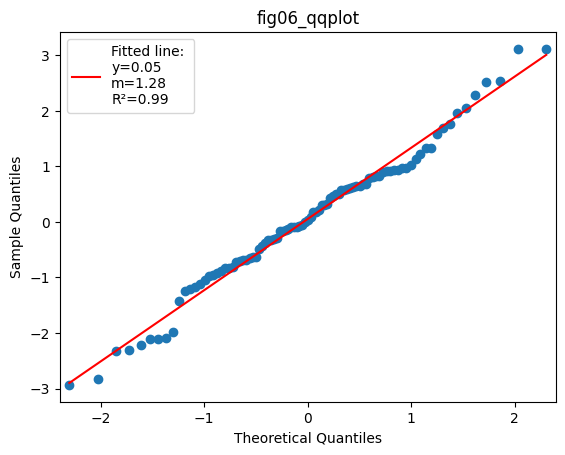

k =  None
The data is NOT normally distributed. p-value: 2.4239753479642076e-10


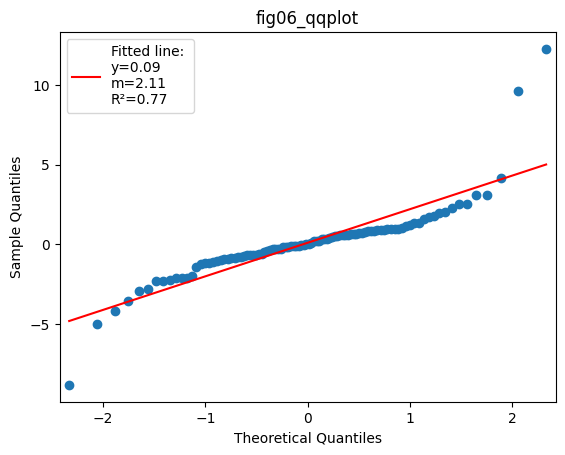

In [10]:
from utils import funs_gp_evaluation
import matplotlib.pyplot as plt

for k in [1.5, None]:  # outlier detection threshold
    print("k = ", k)
    pval = funs_gp_evaluation.test_normality(y_tilde, k)
    slope, intercept, r2 = funs_gp_evaluation.make_qqplot(y_tilde, k, MAKEPLOT=True)
    plt.title("fig06_qqplot")
    plt.show()

In [11]:
data = funs_data_processing.load_data(PROCESSED_TEST_FILE)
data = data.astype(np.float64)
data["y"] = y
data["y_hat"] = y_hat
data["res"] = y - y_hat
data["ares"] = np.abs(y - y_hat)
data["nres"] = y_tilde
data["anres"] = np.abs(y_tilde)
data.head()

,Id,Depth,Diameter,Angle,ThicknessSkin,ThicknessSct,ThicknessAponeurosis,ThicknessLooseAreolarTissue,ThicknessSkullOuter,ThicknessSkullDiploe,...,ConductivityLooseAreolarTissue,ConductivitySkullCortical,ConductivitySkullDiploe,ConductivityCsf,y,y_hat,res,ares,nres,anres
0,15.0,0.050502,0.026897,-1.027950,-0.074498,-0.228085,-0.167527,0.001814,0.089070,0.042896,...,0.290460,-0.169391,-0.305009,0.090675,2032.430,419.361535,1613.068465,1613.068465,12.265351,12.265351
1,13.0,-0.024571,-0.146174,-1.075580,0.267458,0.292351,-0.211020,0.255411,0.268426,-0.175189,...,-0.292252,-0.155304,-0.221874,-0.334509,431.203,65.480426,365.722574,365.722574,1.765402,1.765402
2,6.0,-0.179372,-0.211017,-0.611482,0.084387,-0.005247,-0.026653,-0.316859,-0.285969,0.100773,...,0.171070,-0.027566,0.081609,-0.102199,1514.120,257.654672,1256.465328,1256.465328,9.635547,9.635547
3,67.0,-0.278867,0.224001,0.080903,0.134583,0.228502,-0.027280,-0.604918,-0.318000,-0.149221,...,-0.258935,0.145832,0.091882,0.194548,342.421,239.521898,102.899102,102.899102,0.626899,0.626899
4,43.0,-0.089490,-0.124288,-0.321233,-0.319748,0.284498,-0.188482,1.314670,0.104475,-0.079215,...,-0.274266,0.133154,0.260879,0.087484,311.314,111.892102,199.421898,199.421898,0.785862,0.785862


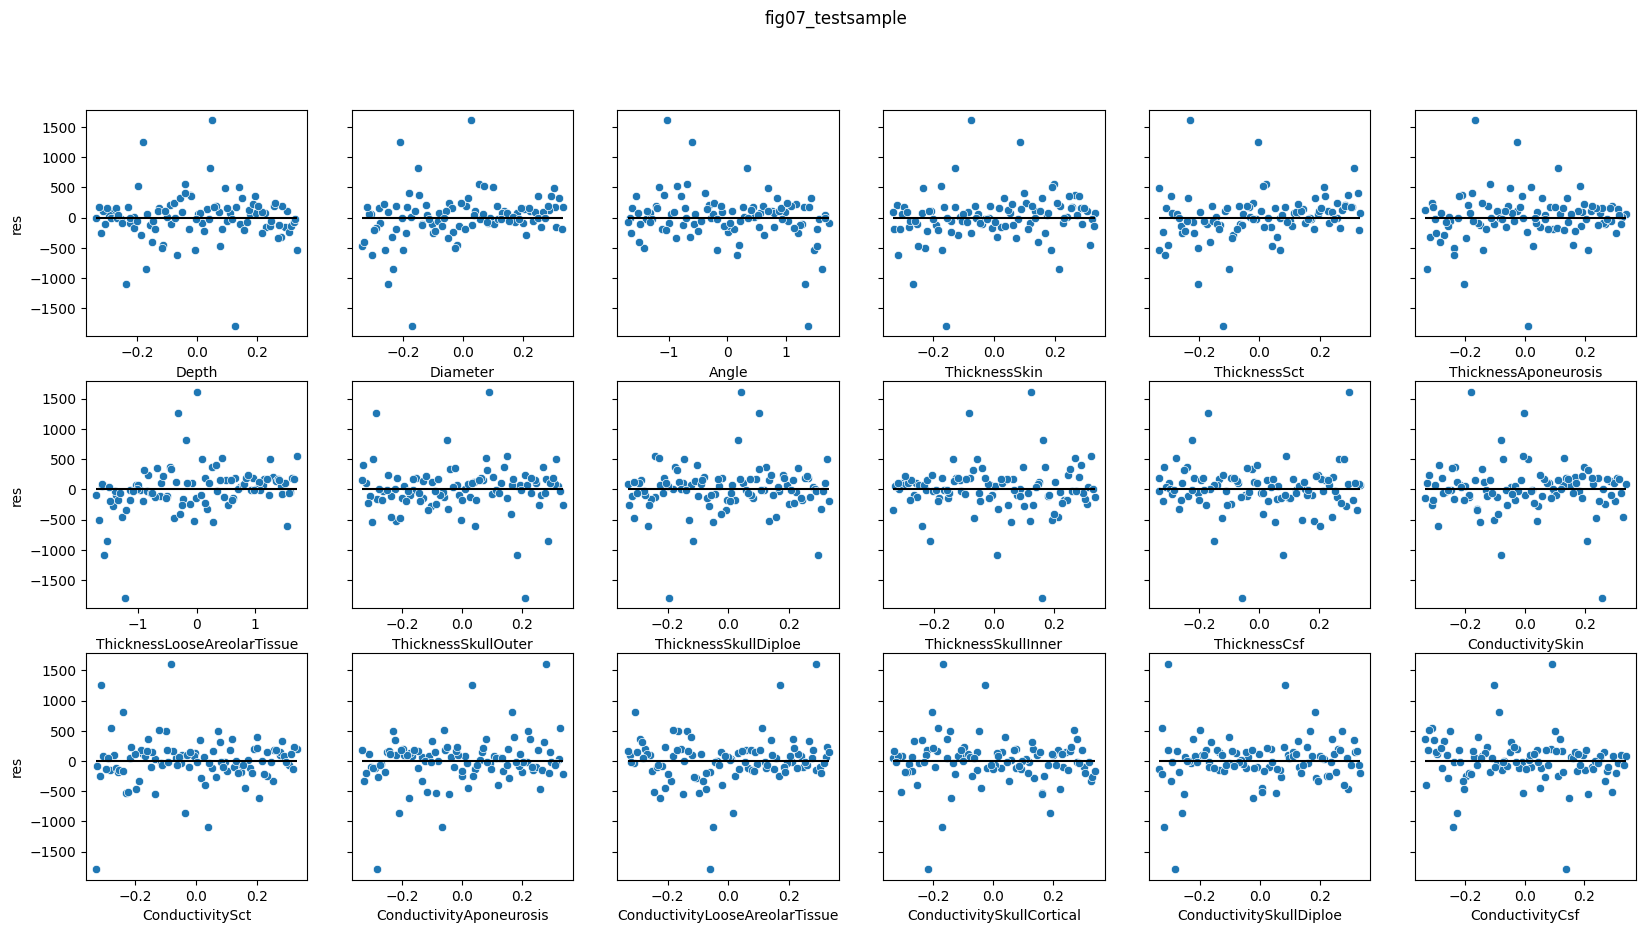

In [12]:
title = "fig07_testsample"

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs: List[plt.Axes] = axs.flatten()
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="res", ax=ax)
    ax.set_xlabel(c)
    ax.hlines(0.0, data[c].min(), data[c].max(), color="black")
plt.suptitle(title)
plt.show()

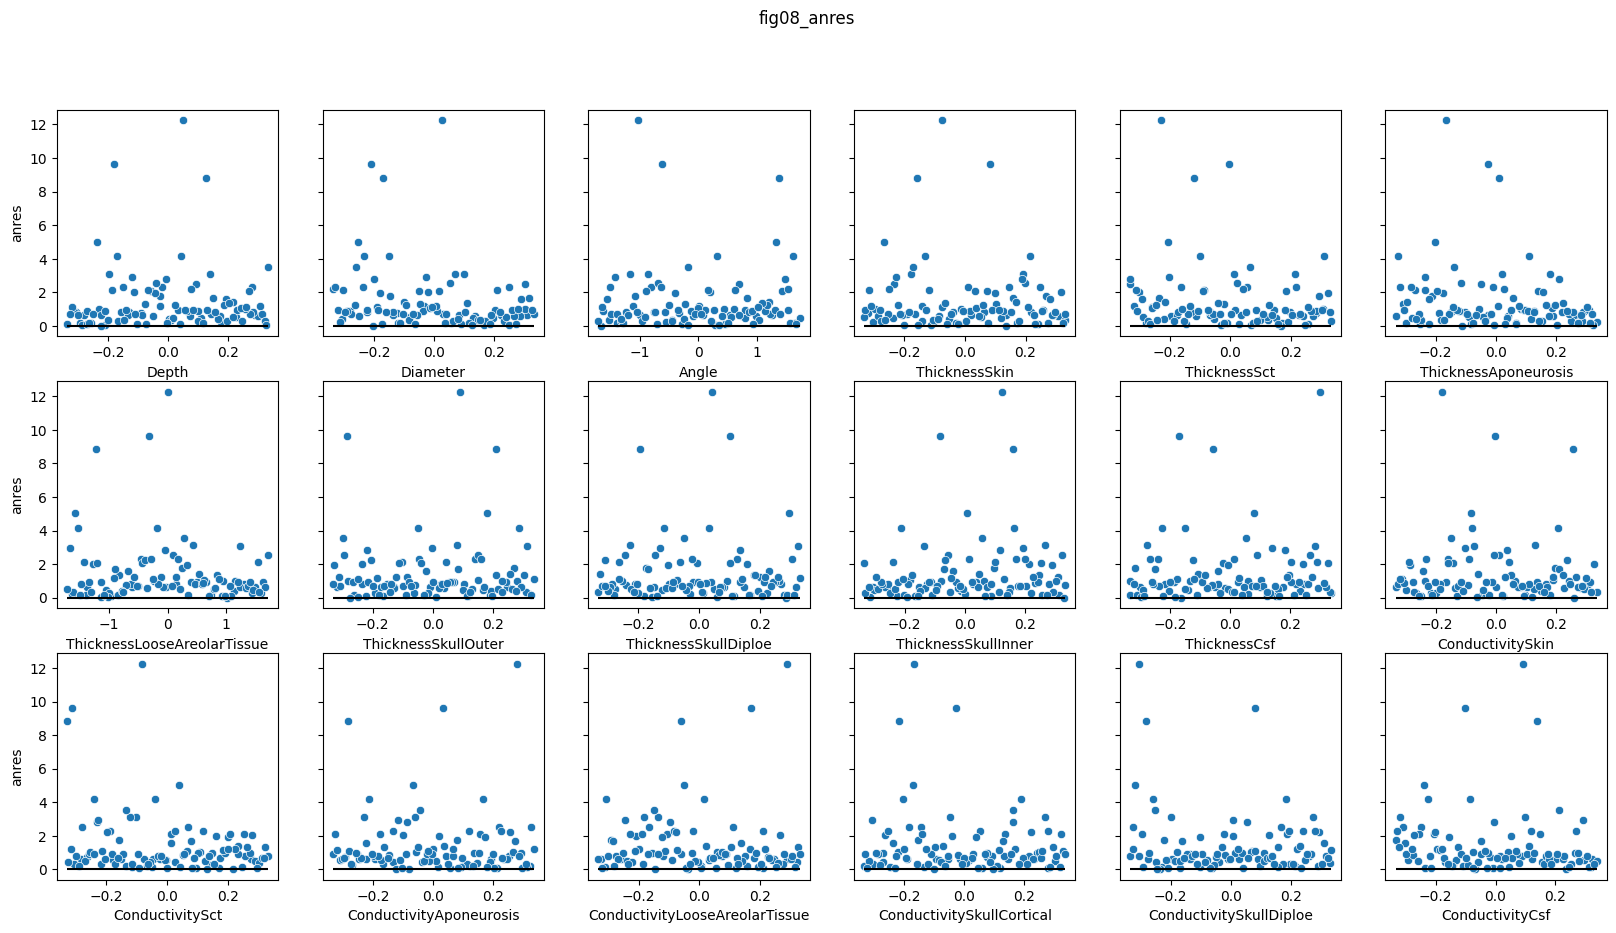

In [13]:
title = "fig08_anres"

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs: List[plt.Axes] = axs.flatten()
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="anres", ax=ax)
    ax.set_xlabel(c)
    ax.hlines(0.0, data[c].min(), data[c].max(), color="black")
plt.suptitle(title)
plt.show()

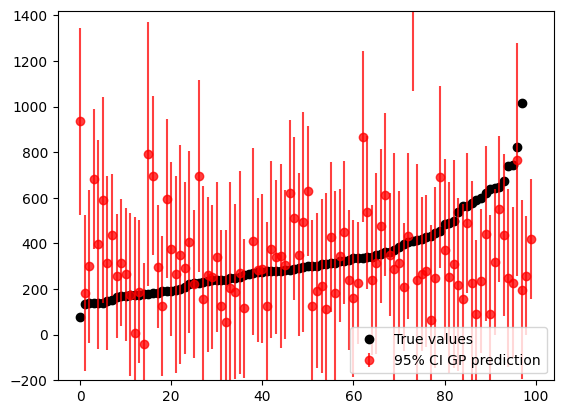

In [21]:
sorted_idx = np.argsort(y)
y = y[sorted_idx]
y_hat = y_hat[sorted_idx]
std = std[sorted_idx]
plt.plot(y, "ko", label="True values")
plt.errorbar(
    range(len(y_hat)),
    y_hat,
    yerr=2 * std,
    fmt="o",
    color="red",
    alpha=0.75,
    label="95% CI GP prediction",
)
plt.ylim(-200, 1420)
plt.legend()